In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np

def one_hot_encode(seq):
    mapping = dict(zip("ACGT", range(4)))    
    seq2 = [mapping[i] for i in seq]
    return np.eye(4, dtype=np.float32)[seq2]

class BiasDataset(Dataset):
    """Background sequences for bias model training"""

    def __init__(self, path_sequences, path_ATAC_signal):
        """
        Arguments:
            path_sequences (string): Path to the pickle file with background regions sequences
            path_ATAC_signal (string): Path to the pickle file with ATAC tracks per datasets and time points

        """
        with open(path_sequences, 'rb') as file:
            self.sequences = pickle.load(file).sequence

        #Encode sequences
        self.len_seq = len(self.sequences.iloc[0])
        self.sequences = self.sequences.apply(lambda x: one_hot_encode(x))

        with open(path_ATAC_signal, 'rb') as file:
            self.ATAC_track = pickle.load(file)
            self.ATAC_track.time = self.ATAC_track.time.astype('category')
            self.ATAC_track.cell_type = self.ATAC_track.cell_type.astype('category')

    def __len__(self):
        return self.ATAC_track.shape[0]

    def __getitem__(self, idx):
        
        track = self.ATAC_track.iloc[idx,0]
        time = self.ATAC_track.iloc[idx,:].time
        cell_type = self.ATAC_track.iloc[idx,:].cell_type

        input = torch.from_numpy(self.sequences[self.ATAC_track.index[idx]])

        return input, time, cell_type, track


In [2]:
import pandas as pd

class PeaksDataset(Dataset):
    """Peaks and background sequences for bias model training"""

    def __init__(self, path_sequences_peaks, path_sequences_back, path_ATAC_peaks, path_ATAC_back):
        """
        Arguments:
            path_sequences_peaks (string): Path to the pickle file with peaks regions sequences
            path_sequences_back (string): Path to the pickle file with background regions sequences
            path_ATAC_peaks (string): Path to the pickle file with ATAC tracks per datasets and time points for peaks regions
            path_ATAC_back (string): Path to the pickle file with ATAC tracks per datasets and time points for background regions

        """
        #Open sequences files
        with open(path_sequences_peaks, 'rb') as file:
            self.sequences = pickle.load(file).sequence

        with open(path_sequences_back, 'rb') as file:
            self.sequences = pd.concat([self.sequences, pickle.load(file).sequence])

        #Encode sequences
        self.len_seq = len(self.sequences.iloc[0])
        self.sequences = self.sequences.apply(lambda x: one_hot_encode(x))

        #Load the ATAC track
        with open(path_ATAC_peaks, 'rb') as file:
            self.ATAC_track = pickle.load(file)

        with open(path_ATAC_back, 'rb') as file:
            self.ATAC_track = pd.concat([self.ATAC_track, pickle.load(file)])

        self.ATAC_track.time = self.ATAC_track.time.astype('category')
        self.time = pd.get_dummies(self.ATAC_track.time, dtype=float)

        self.ATAC_track.cell_type = self.ATAC_track.cell_type.astype('category')
        self.cell_type = pd.get_dummies(self.ATAC_track.cell_type, dtype=float)

        self.ATAC_track = self.ATAC_track.iloc[:,0]

    def __len__(self):
        return self.ATAC_track.shape[0]

    def __getitem__(self, idx):
        
        track = self.ATAC_track.iloc[idx]
        time = self.time.iloc[idx]
        cell_type = self.cell_type.iloc[idx]

        input = torch.from_numpy(self.sequences[self.ATAC_track.index[idx]])

        return input, time, cell_type, track

In [3]:
dataset = BiasDataset('../results/peaks_seq.pkl', '../results/ATAC_peaks.pkl')
dataloader = DataLoader(dataset, batch_size=32,
                        shuffle=True, num_workers=0)

In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class BPNet(nn.Module):
    def __init__(self, nb_conv=8, nb_filters=64, first_kernel=21, rest_kernel=3, profile_kernel_size=75, out_pred_len=1000):
        super().__init__()
        """ BPNet architechture as in paper 
        
        Parameters
        -----------
        nb_conv: int (default 8)
            number of convolutional layers

        nb_filters: int (default 64)
            number of filters in the convolutional layers

        first_kernel: int (default 25)
            size of the kernel in the first convolutional layer

        rest_kernel: int (default 3)
            size of the kernel in all convolutional layers except the first one

        profile_kernel_size: int (default 75)
            size of the kernel in the profile convolution

        out_pred_len: int (default 1000)
            number of bp for which ATAC signal is predicted

        Model Architecture 
        ------------------------

        - Body: sequence of convolutional layers with residual skip connections, dilated convolutions, 
        and  ReLU activation functions

        - Head: 
            > Profile prediction head: a multinomial probability of Tn5 insertion counts at each position 
            in the input sequence, deconvolution layer
            > Total count prediction: the total Tn5 insertion counts over the input region, global average
            poooling and linear layer predicting the total count per strand
        
        The predicted (expected) count at a specific position is a multiplication of the predicted total 
        counts and the multinomial probability at that position.

        -------------------------
        
        Reference: Avsec, Ž., Weilert, M., Shrikumar, A. et al. Base-resolution models of transcription-factor binding 
        reveal soft motif syntax. Nat Genet 53, 354–366 (2021). https://doi.org/10.1038/s41588-021-00782-6

        
        """
        #Define parameters
        self.nb_conv = nb_conv
        self.nb_filters = nb_filters
        self.first_kernel = first_kernel
        self.rest_kernel = rest_kernel
        self.profile_kernel = profile_kernel_size
        self.out_pred_len = out_pred_len

        #Convolutional layers
        self.convlayers = nn.ModuleList()

        self.convlayers.append(nn.Conv1d(in_channels=4, 
                                         out_channels=self.nb_filters,
                                         kernel_size=self.first_kernel))
        for i in range (1,self.nb_conv):
            self.convlayers.append(nn.Conv1d(in_channels=self.nb_filters, 
                                         out_channels=self.nb_filters,
                                         kernel_size=self.rest_kernel,
                                         dilation=2**i))
        #Profile prediction head   
        self.profile_conv = nn.ConvTranspose1d(self.nb_filters, 1, kernel_size=self.profile_kernel)
        self.flatten = nn.Flatten()

        #Total count prediction head
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(self.nb_filters,1)

            
    def forward(self,x):
        
        #Residual + Dilated convolution layers
        #-----------------------------------------------
        x = F.relu(self.convlayers[0](x))

        for layer in self.convlayers[1:]:
            
            conv_x = F.relu(layer(x))

            #Crop output previous layer to size of current 
            x_len = x.size(2); conv_x_len = conv_x.size(2)
            cropsize = (x_len - conv_x_len) // 2
            x = x[:, :, cropsize:-cropsize] 

            #Skipped connection
            x = conv_x + x    

        #Profile head
        #-----------------------------------------------
        profile = self.profile_conv(x)
        
        cropsize = int((profile.size(2)/2) - (self.out_pred_len/2))
        profile = profile[:,:, cropsize:-cropsize]
        
        profile = self.flatten(profile)

        #Total count head
        #-----------------------------------------------
        count = self.global_pool(x)  
        count = count.squeeze()
        count = self.linear(count)

        return x, profile, count

The model predicts the base-resolution 1,000 bp length Tn5 insertion count profile using two complementary outputs: (1) the total Tn5 insertion counts over the 1,000 bp region, and (2) a multinomial probability of Tn5 insertion counts at each position in the 1,000 bp sequence. The predicted (expected) count at a specific position is a multiplication of the predicted total counts and the multinomial probability at that position.

In [7]:
m = BPNet()
input = torch.randn(32, 4, 2114)
print(input.shape)
x, profile, count = m(input)

profile

torch.Size([32, 4, 2114])


tensor([[ 1.8469, -1.7877, -0.0284,  ...,  3.1831,  3.2087,  1.1339],
        [ 0.3837,  1.4284, -1.7782,  ..., -5.2784,  2.3775, -1.4697],
        [ 0.6348,  2.0128,  0.2221,  ..., -4.3641, -3.4889,  1.1216],
        ...,
        [-1.5871, -2.0103, -0.2914,  ..., -4.3922,  0.2921, -2.7903],
        [ 0.3419, -9.5862, -4.3133,  ..., -0.1823, -0.6253, -2.1111],
        [-0.5284,  0.3007,  2.5137,  ..., -1.1071, -3.0132, -0.4747]],
       grad_fn=<ReshapeAliasBackward0>)

BPNet uses a composite loss function consisting of a linear combination of a mean squared error (MSE) loss on the log of the total counts and a multinomial negative log likelihood loss (MNLL) for the profile probability output. We use a weight of [4.9, 4.3, 18.5, 9.8, 8.9, 4.8, 4.6, 4.9, 12.4, 15.4, 4.3, 6.3, 1.4, 2.6, 7.6, 2.3, 16.3, 7.1 & 3.7] for the MSE loss for clusters c0–c20 (c15-c16 combined as one model), and a weight of 1 for the MNLL loss in the linear combination. The MSE loss weight is derived as the median of total counts across all peak regions for each cluster divided by a factor of 10 

In [182]:
#Custom losses functions
from torch.distributions.multinomial import Multinomial

class ATACloss(nn.Module):
    def __init__(self, weight_MSE):
        super().__init__()
        self.weight_MSE = weight_MSE
        self.MSE = nn.MSELoss()

    def forward(self, true_counts, logits, tot_pred):
        counts_per_example = torch.sum(true_counts, dim=1)
        dist = [Multinomial(total_count=x.item(), logits=logits[i,:], validate_args=False) 
                    for i,x in enumerate(torch.round(counts_per_example).type(torch.int32))]

        true_counts = true_counts[:,:1000]
        MNLLL = torch.Tensor([x.log_prob(true_counts[i,:]) for i,x in enumerate(dist)])
        MNLLL = ((-torch.sum(MNLLL))/float(true_counts.shape[0]))

        MSE = self.MSE(counts_per_example, tot_pred.squeeze())

        return self.weight_MSE*MSE + MNLLL


In [183]:
def train(model, criterion, optimizer, num_epochs, dataloader):
    
    losses = []
    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0

        for data in tqdm(dataloader):
            inputs, time, cell_type, tracks = data 
            inputs = torch.reshape(inputs, (-1,4,2114)).to(device)
            tracks = torch.stack(tracks, dim=1).type(torch.float32).to(device)

            optimizer.zero_grad()

            x, profile, count = model(inputs)
            
            loss = criterion(tracks, profile, count)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            losses.append(loss.item())

        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    print('Finished Training')

In [184]:
dataloader = DataLoader(dataset, batch_size=64,
                        shuffle=True, num_workers=0)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

biasModel = BPNet().to(device)
criterion = ATACloss(weight_MSE=1)
optimizer = torch.optim.Adam(biasModel.parameters(), lr=1e-4)

train(biasModel, criterion, optimizer, 1, dataloader)

In [188]:
num_epochs, model = 1, biasModel

losses = []
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0

    for data in tqdm(dataloader):
        inputs, time, cell_type, tracks = data 
        inputs = torch.reshape(inputs, (-1,4,2114))
        tracks = torch.stack(tracks, dim=1).type(torch.float32)

        optimizer.zero_grad()

        x, profile, count = model(inputs)
            
        loss = criterion(tracks, profile, count)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        losses.append(loss.item()/64)

    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print('Finished Training')

  2%|▏         | 305/12480 [16:55<11:15:28,  3.33s/it]


KeyboardInterrupt: 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10ff35590>>
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/LeKIra/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


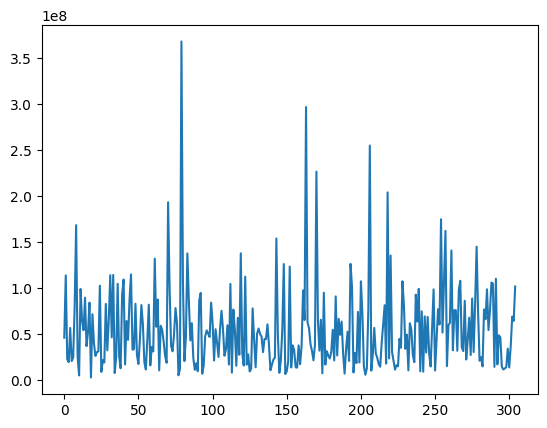

In [189]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
class ModBPNet(nn.Module):
    def __init__(self, nb_conv=8, nb_filters=64, first_kernel=21, rest_kernel=3, profile_kernel_size=75, out_pred_len=1000):
        super().__init__()
        """ 
        
        Parameters
        -----------
        nb_conv: int (default 8)
            number of convolutional layers

        nb_filters: int (default 64)
            number of filters in the convolutional layers

        first_kernel: int (default 25)
            size of the kernel in the first convolutional layer

        rest_kernel: int (default 3)
            size of the kernel in all convolutional layers except the first one

        profile_kernel_size: int (default 75)
            size of the kernel in the profile convolution

        out_pred_len: int (default 1000)
            number of bp for which ATAC signal is predicted

        Model Architecture 
        ------------------------

        - Body: sequence of convolutional layers with residual skip connections, dilated convolutions, 
        and  ReLU activation functions

        - Add metadata (cell type, time point) by concatenating with represention extracted by CN layers 
        - TO DO ..... 

        - Head: 
            > Profile prediction head: a multinomial probability of Tn5 insertion counts at each position 
            in the input sequence, deconvolution layer
            > Total count prediction: the total Tn5 insertion counts over the input region, global average
            poooling and linear layer predicting the total count per strand
        
        The predicted (expected) count at a specific position is a multiplication of the predicted total 
        counts and the multinomial probability at that position.

        -------------------------
        
        Reference: Avsec, Ž., Weilert, M., Shrikumar, A. et al. Base-resolution models of transcription-factor binding 
        reveal soft motif syntax. Nat Genet 53, 354–366 (2021). https://doi.org/10.1038/s41588-021-00782-6

        
        """
        #Define parameters
        self.nb_conv = nb_conv
        self.nb_filters = nb_filters
        self.first_kernel = first_kernel
        self.rest_kernel = rest_kernel
        self.profile_kernel = profile_kernel_size
        self.out_pred_len = out_pred_len

        #Convolutional layers
        self.convlayers = nn.ModuleList()

        self.convlayers.append(nn.Conv1d(in_channels=4, 
                                         out_channels=self.nb_filters,
                                         kernel_size=self.first_kernel))
        for i in range (1,self.nb_conv):
            self.convlayers.append(nn.Conv1d(in_channels=self.nb_filters, 
                                         out_channels=self.nb_filters,
                                         kernel_size=self.rest_kernel,
                                         dilation=2**i))
        #Profile prediction head   
        self.profile_conv = nn.ConvTranspose1d(self.nb_filters, 1, kernel_size=self.profile_kernel)
        self.flatten = nn.Flatten()

        #Total count prediction head
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(self.nb_filters,1)

            
    def forward(self, x, time, cell_type):
        
        #Residual + Dilated convolution layers
        #-----------------------------------------------
        x = F.relu(self.convlayers[0](x))

        for layer in self.convlayers[1:]:
            
            conv_x = F.relu(layer(x))

            #Crop output previous layer to size of current 
            x_len = x.size(2); conv_x_len = conv_x.size(2)
            cropsize = (x_len - conv_x_len) // 2
            x = x[:, :, cropsize:-cropsize] 

            #Skipped connection
            x = conv_x + x    

        #Profile head
        #-----------------------------------------------
        profile = self.profile_conv(x)
        
        cropsize = int((profile.size(2)/2) - (self.out_pred_len/2))
        profile = profile[:,:, cropsize:-cropsize]
        
        profile = self.flatten(profile)

        #Total count head
        #-----------------------------------------------
        count = self.global_pool(x)  
        count = count.squeeze()
        count = self.linear(count)

        return x, profile, count